In [55]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d, fftconvolve
from cv2 import imwrite, imread
import tifffile as tiff

In [32]:
camara_pixel_size = 5000 # nm
camara_pixels_number = 256
line_length = 200 # pixels
camara_size = camara_pixel_size * camara_pixels_number 
NA = 1.4 # numerical aperture
MA = 500 # magnification
collect_number = 400 # number of collected photos
physical_pixel_size = camara_pixel_size / MA 
physical_size = camara_size / MA 
excitation_wavelength = 488 # nm
emission_wavelength = 520 # nm
diffraction_limit = 0.5 * emission_wavelength / NA 

In [33]:
def generate_psf(camara_pixels_number, physical_pixel_size, wavelength, NA):
    # 计算频率范围
    freq = np.fft.fftfreq(camara_pixels_number, d=physical_pixel_size/2)#这里为什么除2我也不知道
    fx, fy = np.meshgrid(freq, freq)
    f_r = np.sqrt(fx**2 + fy**2)
    
    # 计算截止频率
    cutoff_frequency = 2 * NA / wavelength
    
    # 生成光瞳函数
    pupil_function = f_r <= cutoff_frequency

    # 计算点扩散函数
    psf = np.abs(ifftshift(ifft2(fftshift(pupil_function))))**2
    psf /= psf.max()  
    
    return psf

In [34]:
line_pairs_spacing = [80, 100, 120, 140, 160, 180] # nm
line_pairs_spacing = np.array(line_pairs_spacing)
line_pairs_spacing_by_pixel = line_pairs_spacing * MA / camara_pixel_size    # in pixel size


In [6]:
def generate_line_pairs(camara_pixels_number, line_spacing_by_pixel = 20, line_width = 1, line_length = 200, line_pairs_number = 1):
    
    # 创建一个的黑色图像
    image_array = np.zeros((camara_pixels_number, camara_pixels_number//line_pairs_number))

    # 线的间距和宽度和长度
    line_spacing_by_pixel = round(line_spacing_by_pixel)
    line_width = round(line_width)
    line_length = round(line_length)
    
    # 计算线的位置
    center_x = image_array.shape[1] // 2
    center_y = image_array.shape[0] // 2

    # 第一条线的起始和结束位置
    line1_start_x = center_x - round(line_spacing_by_pixel / 2) - line_width
    line1_end_x = line1_start_x + line_width
    line1_start_y = center_y - line_length // 2
    line1_end_y = line1_start_y + line_length

    # 第二条线的起始和结束位置
    line2_start_x = center_x + round(line_spacing_by_pixel / 2)
    line2_end_x = line2_start_x + line_width
    line2_start_y = center_y - line_length // 2
    line2_end_y = line2_start_y + line_length

    # 绘制第一条线
    image_array[line1_start_y:line1_end_y, line1_start_x:line1_end_x] = 1

    # 绘制第二条线
    image_array[line2_start_y:line2_end_y, line2_start_x:line2_end_x] = 1
    
    return image_array

(256, 256)
1.0 0.0


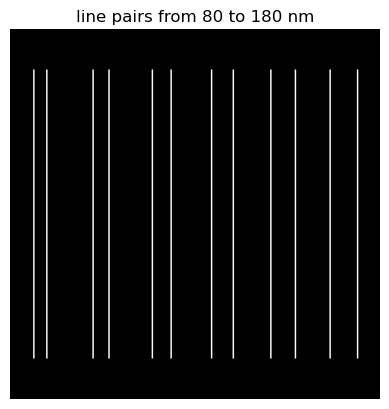

In [ ]:
images = [generate_line_pairs(camara_pixels_number, spacing, line_pairs_number = len(line_pairs_spacing_by_pixel), 
                              line_length = line_length) for spacing in line_pairs_spacing_by_pixel]
ground_truth = np.hstack(images)
ground_truth = np.pad(ground_truth, ((0, 0), (0, camara_pixels_number - ground_truth.shape[1])), 
                      mode='constant', constant_values=0)
print(ground_truth.shape)
print(ground_truth.max(), ground_truth.min())
# imwrite(f'line_pairs_{camara_pixels_number}_{line_pairs_spacing.min()}to{line_pairs_spacing.max()}nm.tiff',
#         (ground_truth * 255).astype(np.uint8))
plt.imshow(ground_truth, cmap='gray')
plt.title(f"line pairs from {line_pairs_spacing.min()} to {line_pairs_spacing.max()} nm")
plt.axis('off')
plt.show()

(256, 256)
1.0 4.707284045955073e-11


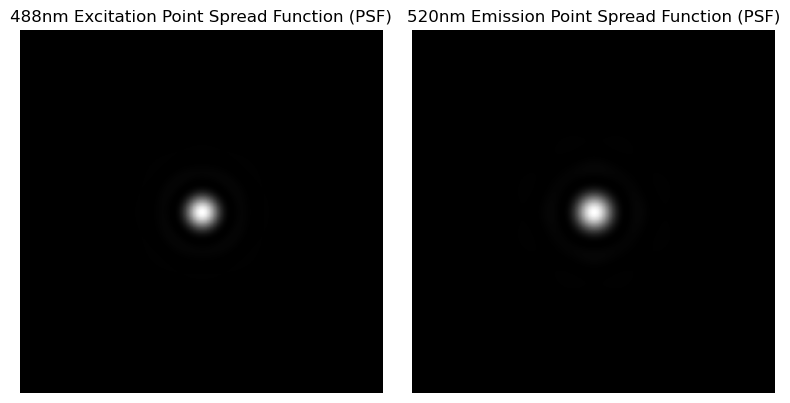

In [ ]:
excitation_psf = generate_psf(camara_pixels_number, physical_pixel_size, excitation_wavelength, NA)
emission_psf = generate_psf(camara_pixels_number, physical_pixel_size, emission_wavelength, NA)

#print(excitation_psf.dtype)
#print(np.max(excitation_psf))
# 显示激发点扩散函数和发射点扩散函数并列
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# 激发点扩散函数
axes[0].imshow(excitation_psf, cmap='gray')
axes[0].set_title(f"{excitation_wavelength}nm Excitation Point Spread Function (PSF)")
axes[0].axis('off')

# 发射点扩散函数
axes[1].imshow(emission_psf, cmap='gray')
axes[1].set_title(f"{emission_wavelength}nm Emission Point Spread Function (PSF)")
axes[1].axis('off')

print(excitation_psf.shape)
print(excitation_psf.max(), excitation_psf.min())
# imwrite(f'PSF{camara_pixels_number}_{excitation_wavelength}nm.tif',(excitation_psf * 255).astype(np.uint8))
# imwrite(f'PSF{camara_pixels_number}_{emission_wavelength}nm.tif',(emission_psf * 255).astype(np.uint8))

plt.tight_layout()
plt.show()

1.0


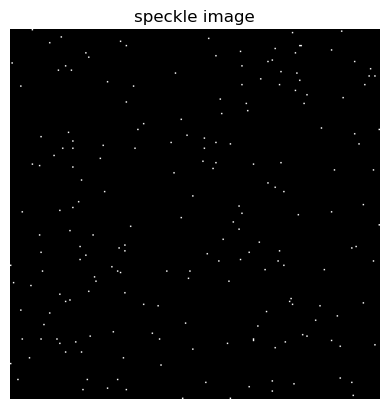

In [ ]:
speckle_image = np.zeros((camara_pixels_number, camara_pixels_number))
speckle_images = np.zeros((collect_number, camara_pixels_number, camara_pixels_number))
num_speckles = 200 # 每张图像中的散斑数量

for i in range(collect_number):
    indices = np.random.choice(camara_pixels_number * camara_pixels_number, num_speckles, replace=False)
    speckle_image[np.unravel_index(indices, (camara_pixels_number, camara_pixels_number))] = 1
    speckle_images[i, :, :] = speckle_image.copy()
    speckle_image.fill(0)  # 清空图像以便下次使用

# 显示随机散斑图片
# imwrite(f'speckle_image_num={num_speckles}.tiff',(speckle_images[collect_number//2, :, :] * 255).astype(np.uint8))
plt.imshow(speckle_images[collect_number//2, :, :], cmap='gray')
plt.title("speckle image")
plt.axis('off')  # 不显示坐标轴
plt.show()

1.0 0.0022023284747212267


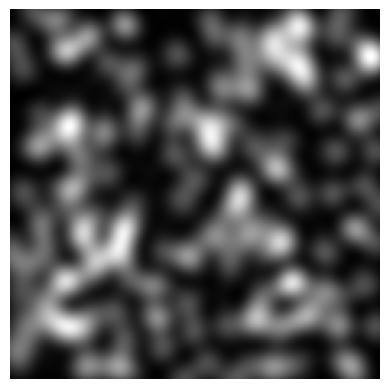

In [48]:
# 对散斑图片进行卷积
convolved_speckle_images = np.zeros((collect_number, camara_pixels_number, camara_pixels_number))

for i in range(collect_number):
    convolved_speckle_image = fftconvolve(speckle_images[i, :, :], excitation_psf, mode='same')
    convolved_speckle_image /= convolved_speckle_image.max()  # 归一化
    convolved_speckle_images[i, :, :] = convolved_speckle_image.copy() # 归一化

print(convolved_speckle_images.max(), convolved_speckle_images.min())
imwrite(f'convolved_speckle_images_num={num_speckles}.tiff',
        (convolved_speckle_images[collect_number//2, :, :] * 255).astype(np.uint8))

# 显示卷积后的图像
#plt.figure(figsize=(18, 9))
plt.imshow(convolved_speckle_images[collect_number//2, :, :], cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()

1.0 0.0


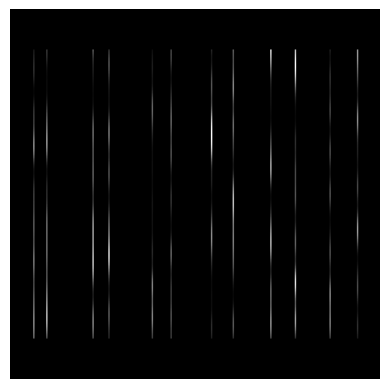

In [51]:
illuminate_images = np.zeros((collect_number, camara_pixels_number, camara_pixels_number))
for i in range(collect_number):
    illuminate_images[i, :, :] = convolved_speckle_images[i, :, :] * ground_truth

print(illuminate_images.max(), illuminate_images.min())

imwrite(f'illuminate_images.tiff', (illuminate_images[collect_number//2, :, :] * 255).astype(np.uint8))

# 展示结果图像
plt.imshow(illuminate_images[collect_number//2, :, :], cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()

# 存储为8位灰度图像tiff格式
# image = Image.fromarray(np.uint8(illuminate_images[400, :, :]*255))
# image.save('sample_illu.tif')

float64
65535.0 0.000783275230486651


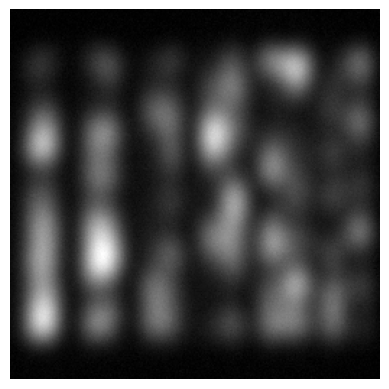

In [56]:

collected_images = np.zeros((collect_number, camara_pixels_number, camara_pixels_number))
for i in range(collect_number):
    collected_images[i, :, :] = fftconvolve(illuminate_images[i, :, :], emission_psf, mode='same')
    collected_images[i, :, :] = abs(np.random.normal(collected_images[i, :, :], 0.01*collected_images[i, :, :].max()))
    collected_images[i, :, :] = collected_images[i, :, :]/np.max(collected_images[i, :, :]) * (2**16-1)
    #collected_images[i, :, :] = np.clip(collected_images[i, :, :], 0, 1e10)  # 限制数据范围
    #collected_images[i, :, :] = np.random.poisson(collected_images[i, :, :])

print(collected_images.dtype)
print(collected_images.max(), collected_images.min())

tiff.imwrite(
    f'collected_images{camara_pixels_number}_{collect_number}frame_{emission_wavelength}{excitation_wavelength}nm.tiff',
    collected_images.astype(np.uint16))
# 显示卷积后的图像
plt.imshow(collected_images[collect_number//2, :, :], cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()


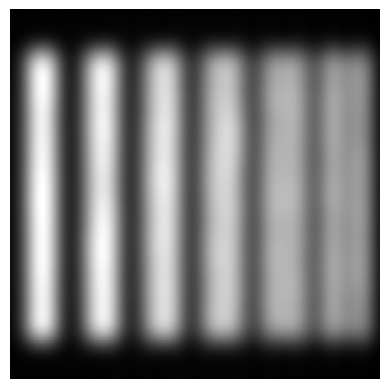

In [58]:
average_image = np.mean(collected_images, axis=0)
average_image /= np.max(average_image)  # 归一化
average_image *= (2**8-1)  # 归一化到16位范围
imwrite(f'average_image.tiff',average_image.astype(np.uint8))
# 显示平均的图像

plt.imshow(average_image, cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()


255.0


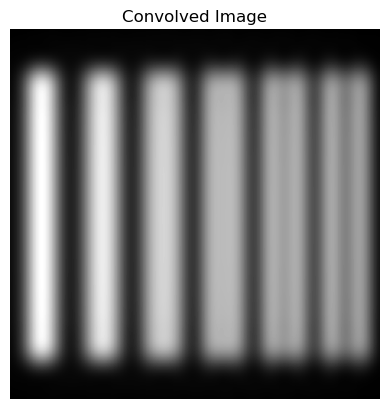

In [60]:
# 对 ground_truth 和 psf 进行卷积
convolved_image = fftconvolve(ground_truth, excitation_psf, mode='same')
convolved_image /= convolved_image.max()  # 归一化
convolved_image *= (2**8-1)  # 归一化到16位范围
print(np.max(convolved_image))
imwrite(f'convolved_image.tiff',convolved_image.astype(np.uint8))
# 显示卷积后的图像

plt.imshow(convolved_image, cmap='gray')
plt.title("Convolved Image")
plt.axis('off')
plt.show()